In [1]:
import nltk
import pandas as pd
import numpy as np
import nhandv6_text_processing as dvnt
import nhandv6_classification as dvn_c
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_validate

2021-11-24 09:13:19.674544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 09:13:19.674589: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## A. Theory 
### 1. CountVectorizer

In [2]:
corpus = ['this is the first document',
          'this document is the second document',
          'and this is the third one',
          'is this the first document?',
          'this Document is not yours..']

dvnt.view_word_freq(corpus)

*====================================================================================================
|There are 5 sentences in this corpus.
|====================================================================================================
|The number of the different words is 11, and ... they are:
|====================================================================================================
*	 1: and,
*	 2: document,
*	 3: first,
*	 4: is,
*	 5: not,
*	 6: one,
*	 7: second,
*	 8: the,
*	 9: third,
*	 10: this,
*	 11: yours,


,and,document,first,is,not,one,second,the,third,this,yours
this is the first document,0,1,1,1,0,0,0,1,0,1,0
this document is the second document,0,2,0,1,0,0,1,1,0,1,0
and this is the third one,1,0,0,1,0,1,0,1,1,1,0
is this the first document?,0,1,1,1,0,0,0,1,0,1,0
this Document is not yours..,0,1,0,1,1,0,0,0,0,1,1


### 2. Tfidf vectorizer

In [3]:
dvnt.view_Tfidf(corpus)

,and,document,first,is,not,one,second,the,third,this,yours
this is the first document,0.000000,0.427120,0.611659,0.361255,0.000000,0.000000,0.000000,0.427120,0.000000,0.361255,0.000000
this document is the second document,0.000000,0.646126,0.000000,0.273244,0.000000,0.000000,0.573434,0.323063,0.000000,0.273244,0.000000
and this is the third one,0.514923,0.000000,0.000000,0.245363,0.000000,0.514923,0.000000,0.290099,0.514923,0.245363,0.000000
is this the first document?,0.000000,0.427120,0.611659,0.361255,0.000000,0.000000,0.000000,0.427120,0.000000,0.361255,0.000000
this Document is not yours..,0.000000,0.338411,0.000000,0.286226,0.600678,0.000000,0.000000,0.000000,0.000000,0.286226,0.600678


In [4]:
df = dvnt.view_word_freq(corpus, show_info = False).reset_index().rename(columns = {'index': 'my_text'})[['my_text']]
dvnt.textdata_to_countvect(df, 'my_text')

,my_text,and,document,first,is,not,one,second,the,third,this,yours
0,this is the first document,0,1,1,1,0,0,0,1,0,1,0
1,this document is the second document,0,2,0,1,0,0,1,1,0,1,0
2,and this is the third one,1,0,0,1,0,1,0,1,1,1,0
3,is this the first document?,0,1,1,1,0,0,0,1,0,1,0
4,this Document is not yours..,0,1,0,1,1,0,0,0,0,1,1


In [5]:
dvnt.textdata_to_TFIDF(df, 'my_text')

,my_text,and,document,first,is,not,one,second,the,third,this,yours
0,this is the first document,0.000000,0.427120,0.611659,0.361255,0.000000,0.000000,0.000000,0.427120,0.000000,0.361255,0.000000
1,this document is the second document,0.000000,0.646126,0.000000,0.273244,0.000000,0.000000,0.573434,0.323063,0.000000,0.273244,0.000000
2,and this is the third one,0.514923,0.000000,0.000000,0.245363,0.000000,0.514923,0.000000,0.290099,0.514923,0.245363,0.000000
3,is this the first document?,0.000000,0.427120,0.611659,0.361255,0.000000,0.000000,0.000000,0.427120,0.000000,0.361255,0.000000
4,this Document is not yours..,0.000000,0.338411,0.000000,0.286226,0.600678,0.000000,0.000000,0.000000,0.000000,0.286226,0.600678


### 3. Special signals

| Cases | Examples (discriptions) | 
|:-|:-| 
| `number of hastags` | #memories
| `number of url_link and unique url in` <br> `email, messages / tweets / etc` <br> | `https//:google.com` |
| `mention someone else` | @David
| `hour of day / day of week / or any` <br> `mentioned-timestamp when the email` or <br> `messages / tweets was send / posted` <br> | `2020-12-12`, `21 Jun 2020`, `etc`
| `number of emojicon` | `:)`, `:v`, `=))`, `etc`
| `number of capitalized words` | AbBa MoHameD
| `sum of all the character-lengths of word` | `len`(word_splited)
| `number of words containing letters` <br> and `numbers` <br> | 128abc9*, 29Jun, `etc`
| `number of words containing` **only** `numbers` <br> **or** `letters` <br> | 123St, 92.No
| `max ratio of digit characters to all` <br> `characters of each word` <br> | `max`([`len`(digit(word)) / `len`(word) `for` word `in` words])
| `max the charecter-lengths of all words.` | `max`([`len`(word) `for` word `in` words])
| `number of words in email, messages` or <br> `tweets / etc` <br> | `len`(word.split()) |
| `max length of word` | `max`([`len`(w) `for` w `in` words])
| `average length of word` | `mean`([`len`(w) `for` w `in` words])
| `number of punctuation` |

In [6]:
text = ["click https://www.kaggle.com/ and https://seaborn.pydata.org. 123go to receive free-gift!! \U0001F600 SaiGon 2022/12-01",
        "@David Life is suffering, please came back! 12people in our class has been failed! \U0001F64F, please contact Prof.Elena",
        "your update Verison has been rejected, we can't finish downloading your update! Please try again later",
        "#memory, #Thanksgiving at #NewYork City!?% 25 Nov 2021, Happy with @Alex @Ashley @David and @Charles! NY; 25 Nov, 2021",        
        "Good morning, how are you",
        "123jerky =)) @LOL is feeling happy, #EA-Sport submitted to surname@hotmail.com",
        "The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam"
       ]
df = pd.DataFrame({'text': text})
%time dvnt.view_url_emoij_etc(df, 'text')

CPU times: user 58.3 ms, sys: 10.6 ms, total: 68.9 ms
Wall time: 104 ms


,text,wcount,unq_wcount,stop_word_count,url_count,avg_wlen,char_count,punct_count,hastg_count,mentn_count,max_wlen,emoji_cnt,capt_cnt,email_cnt,time_cnt,char&num_cnt,max_digit_rate
0,click https://www.kaggle.com/ and https://seab...,11,11,2,2,9.090909,110,17,0,0,27,1,2,0,1,1,1.0
1,"@David Life is suffering, please came back! 12...",18,17,5,0,5.222222,111,6,0,1,10,0,4,0,0,1,1.0
2,"your update Verison has been rejected, we can'...",16,15,7,0,5.437500,102,3,0,0,11,0,2,0,0,0,0.0
3,"#memory, #Thanksgiving at #NewYork City!?% 25 ...",19,18,3,0,5.263158,118,15,3,4,13,0,13,0,2,0,1.0
4,"Good morning, how are you",5,5,3,0,4.200000,25,1,0,0,8,0,1,0,0,0,0.0
5,"123jerky =)) @LOL is feeling happy, #EA-Sport ...",10,10,2,0,6.900000,78,9,1,2,19,1,6,1,0,1,1.0
6,The SMS Spam Collection is a set of SMS tagged...,38,29,14,0,4.710526,216,5,0,0,12,0,18,0,1,0,1.0


### Cleansing text

In [7]:
init_text = "\U0001F600-\U0001F64F heallo, haev a godo jbo, todyao is 29Jun2021 !\nPlesAe Visit https://google.com.vn and contact abc2083181@yahoo.com"
dvnt.basic_clean_text(init_text, True)

Initial input strings: '😀-🙏 heallo, haev a godo jbo, todyao is 29Jun2021 !
PlesAe Visit https://google.com.vn and contact abc2083181@yahoo.com'.
Word-list fter cleansing: '['hello', 'have', 'a', 'good', 'job', 'today', 'is', '29jun2021', 'please', 'visit', 'and', 'contact']
========================================================================================================================'
Email detected: abc2083181@yahoo.com
url_link detected: https://google.com.vn
The first timestamp detected: 29/06/2021


['hello',
 'have',
 'a',
 'good',
 'job',
 'today',
 'is',
 '29jun2021',
 'please',
 'visit',
 'and',
 'contact']

### 4. Co-occurence matrix

In [8]:
corpus = ["I love you and football",
          "Dont worried! :D just kidding www.google.com.vn", 
          "I love statistics :v",
          "I love Machine Learning and Mathematics"]
dvnt.get_co_occurence_matrix(corpus)

,dont,and,statistics,worried,you,mathematics,learning,love,kidding,machine,just,i,football
dont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
and,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
statistics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
worried,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
you,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
mathematics,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
learning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
love,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
kidding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
machine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### 5. N-grams analytics

In [9]:
df['target'] = ["spam", "spam", "no-spam", "spam", "no-spam", "spam", "no-spam"]
df = df[['text', 'target']]
df

,text,target
0,click https://www.kaggle.com/ and https://seab...,spam
1,"@David Life is suffering, please came back! 12...",spam
2,"your update Verison has been rejected, we can'...",no-spam
3,"#memory, #Thanksgiving at #NewYork City!?% 25 ...",spam
4,"Good morning, how are you",no-spam
5,"123jerky =)) @LOL is feeling happy, #EA-Sport ...",spam
6,The SMS Spam Collection is a set of SMS tagged...,no-spam


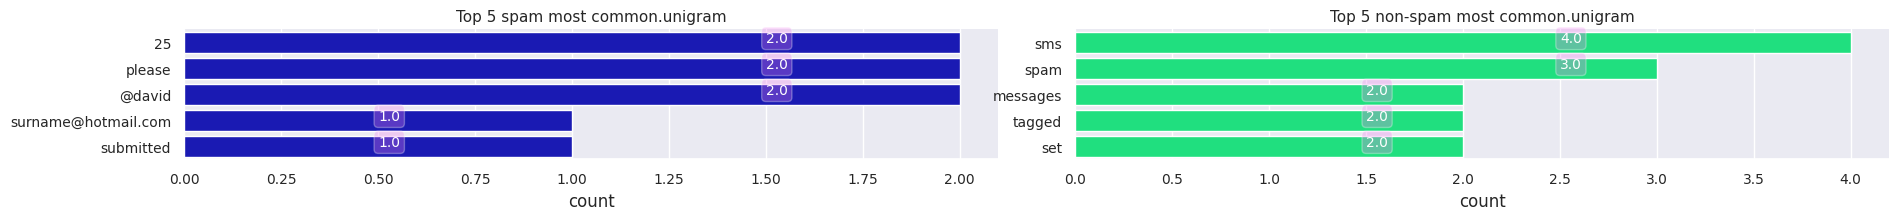

In [10]:
dvnt.N_grams_data_show(df, 'text', 'target', 'spam', 1, 5)

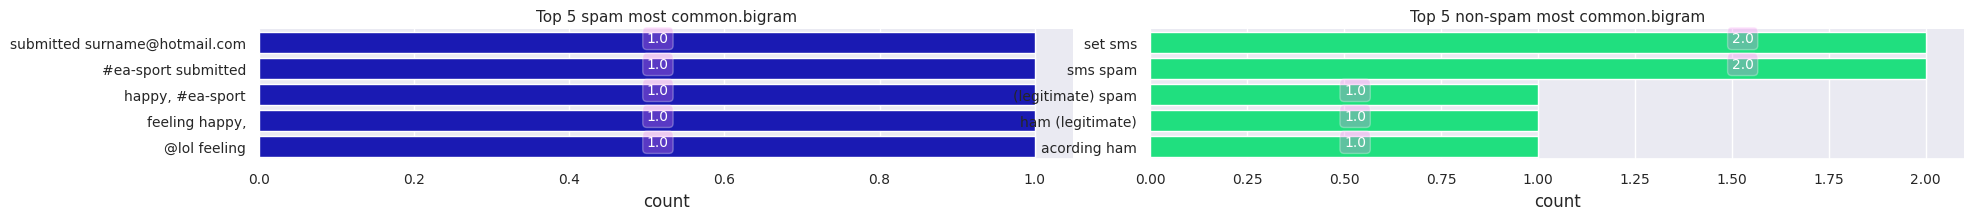

In [11]:
dvnt.N_grams_data_show(df, 'text', 'target', 'spam', 2, 5)

# B. Example in `spam-detection`

In [12]:
url_link = "https://raw.githubusercontent.com/Nhan121/Lectures_notes-teaching-in-VN-/master/US-Embassy_DS-course/Class%203/Datasets/spam.csv"
spam_df = pd.read_csv(url_link)
spam_df.head()

,target,text,discription,key_word,ukn_col
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### B.1. Initial checking

In [13]:
import nhandv6_classification as dvnc

display(dvnc.table_count_null(spam_df))
display(dvnc.table_count_unique(spam_df))
tweet = dvnc.data_duplicate(spam_df)

,target,text,discription,key_word,ukn_col
column_type,object,object,object,object,object
cnt_null_data (nb),0,0,7600,7633,5164
cnt_null_data (%),0.0,0.0,99.424385,99.856096,67.556253


,target,text,discription,key_word,ukn_col
column_type,object,object,object,object,object
cnt_unique (nb),2,7644,44,11,15
most_appeared_value,[ham],"[ &lt;#&gt; in mca. But not conform., &lt;#&...",[ PO Box 5249],"[ MK17 92H. 450Ppw 16""]",[bitcoin]
cnt_occurrences (nb),4516,7644,2,2,526
cnt_occurrences (%),59.079016,100.0,0.026164,0.026164,6.881214


|****************************************************************************************************
|	The initial_shape of your dataset is (7644, 5)
|----------------------------------------------------------------------------------------------------
|	Number of duplicated-values = 0, about 0.0% of initial dataset.
|----------------------------------------------------------------------------------------------------
|	Viewing the first 5 rows.
|****************************************************************************************************


,target,text,discription,key_word,ukn_col
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


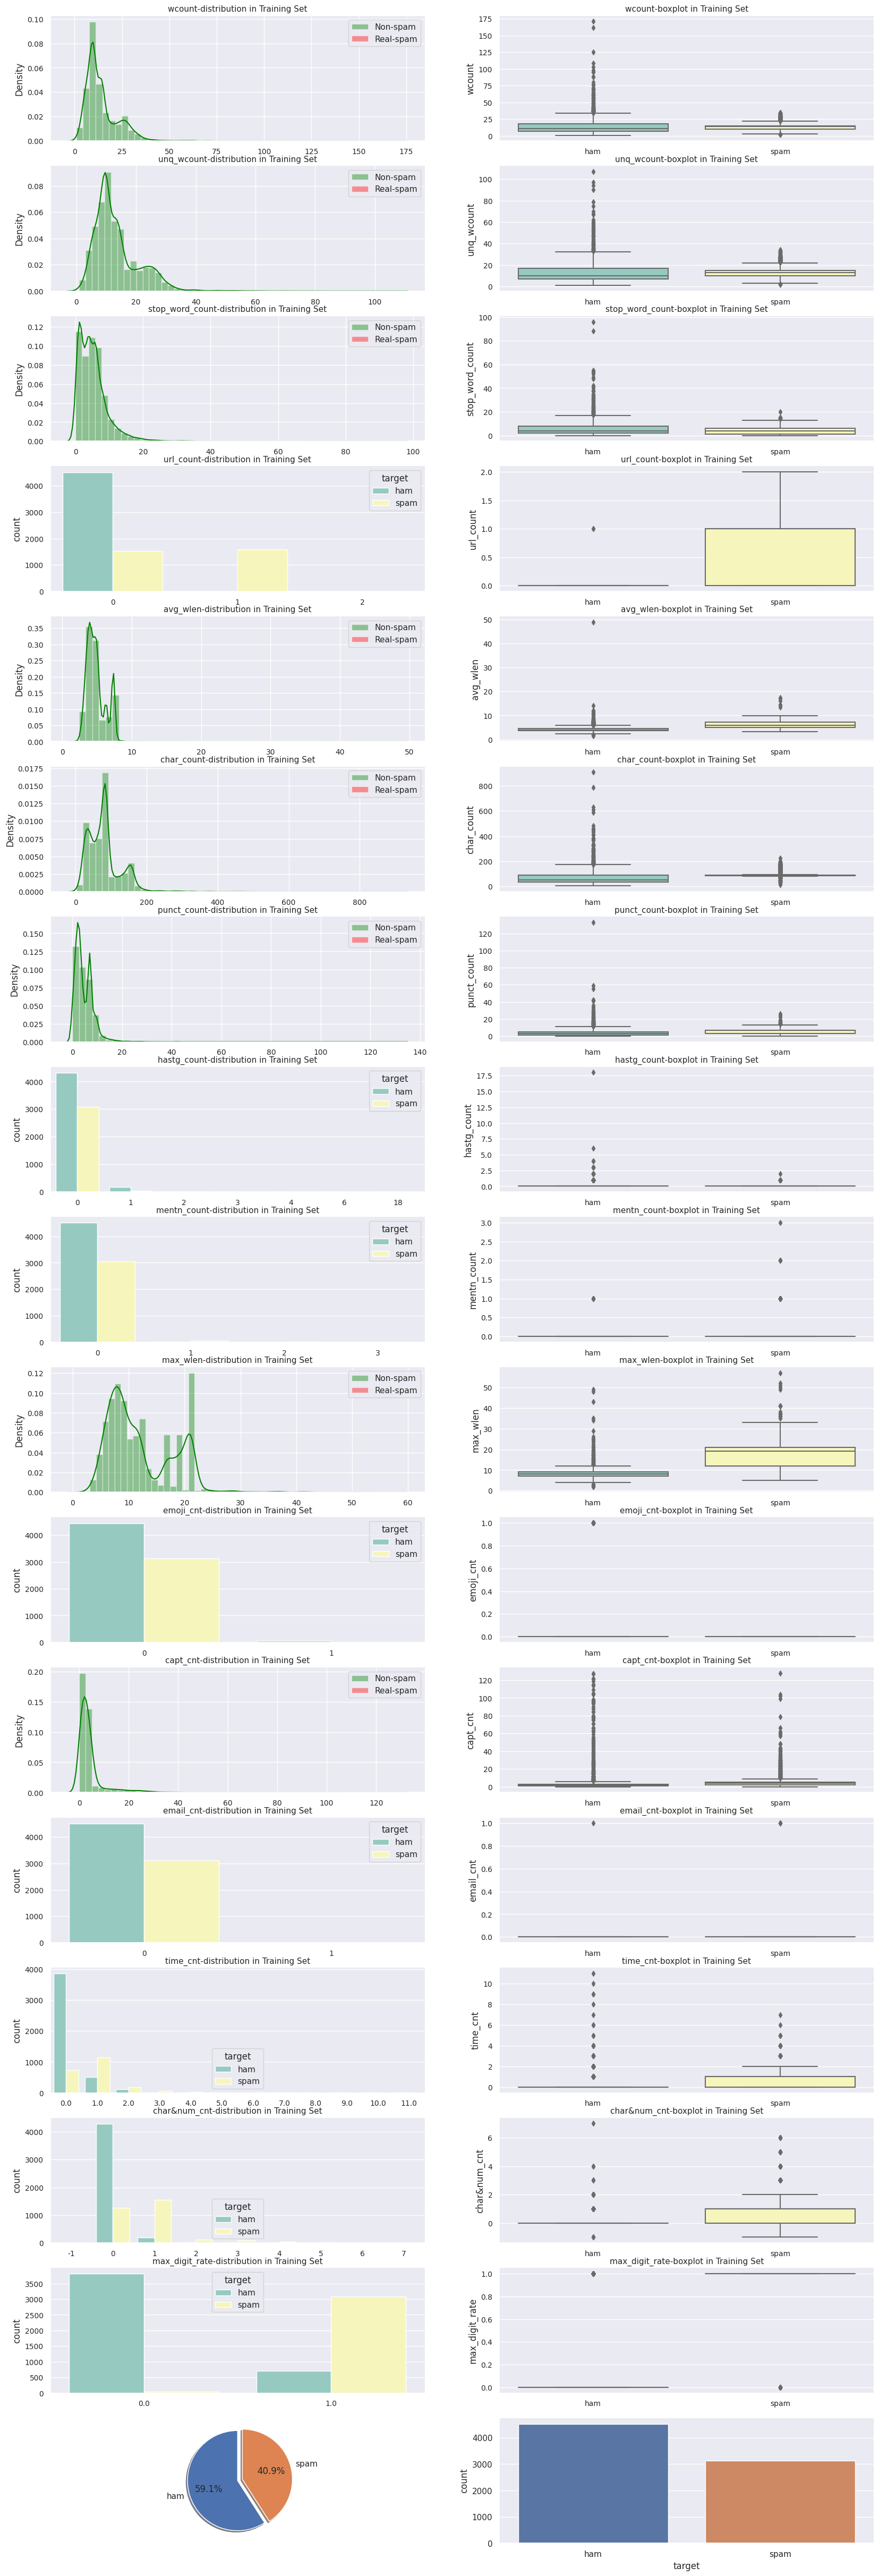

In [14]:
import matplotlib.pyplot as plt

clf_col = 'target'
text_col = 'text'
    
encode_data = dvnt.view_url_emoij_etc(spam_df, text_col)
dvnt.metafeature_view(spam_df, text_col, clf_col, obs_val = 'real_spam')

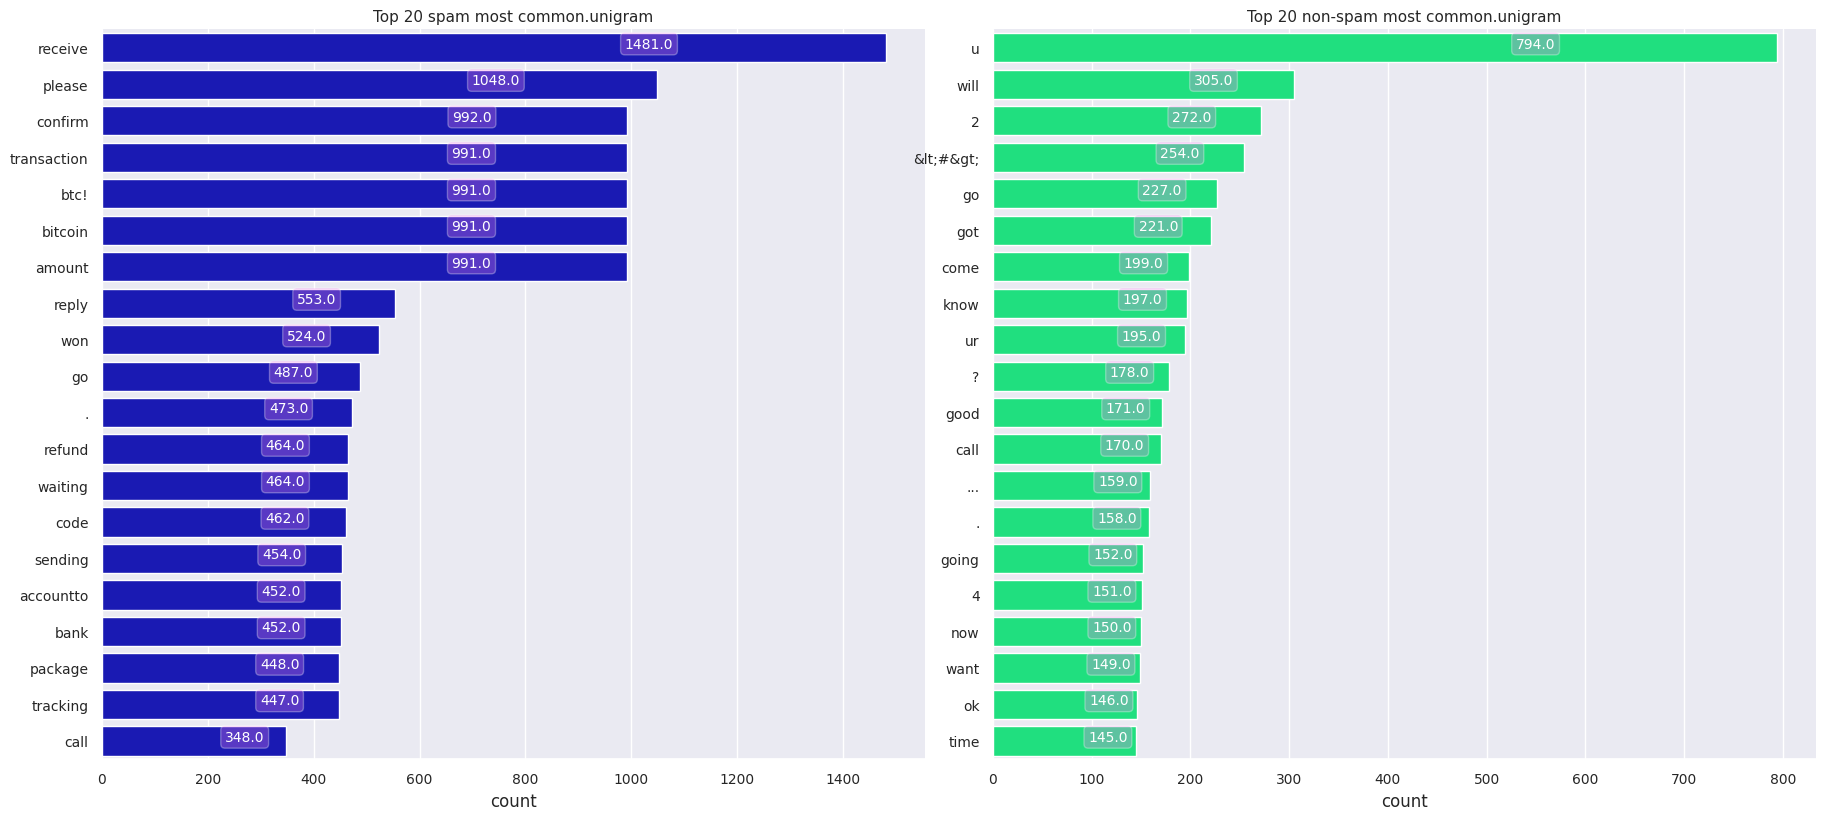

In [15]:
dvnt.N_grams_data_show(spam_df, 'text', 'target', 'spam', 1, 20)

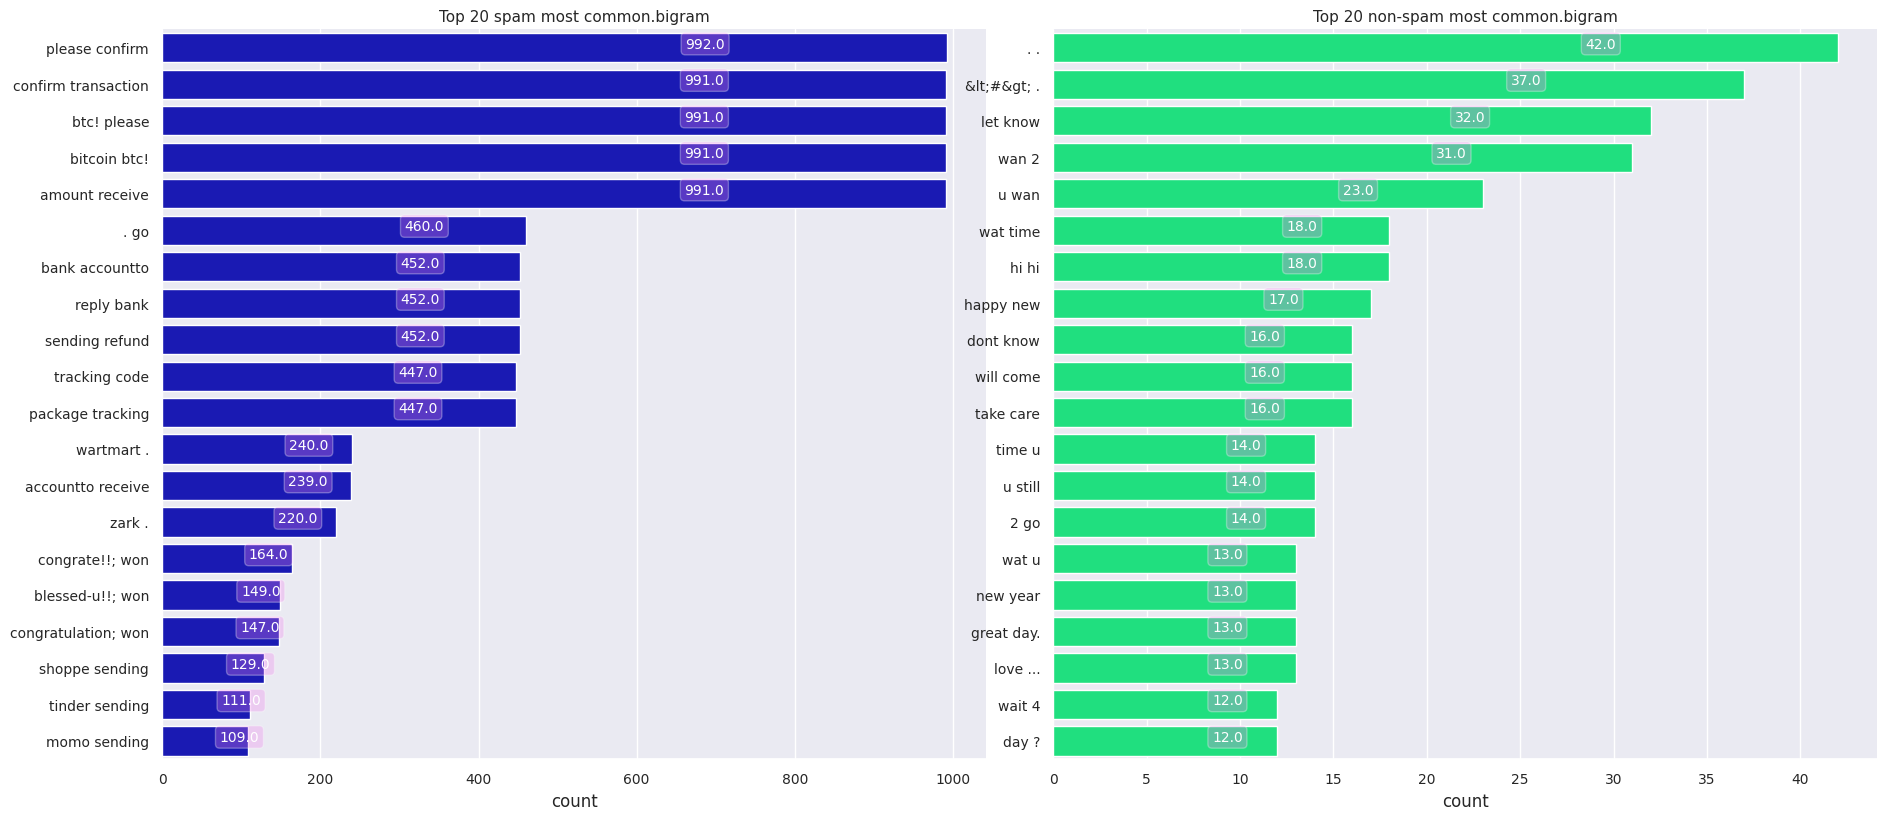

In [16]:
dvnt.N_grams_data_show(spam_df, 'text', 'target', 'spam', 2, 20)

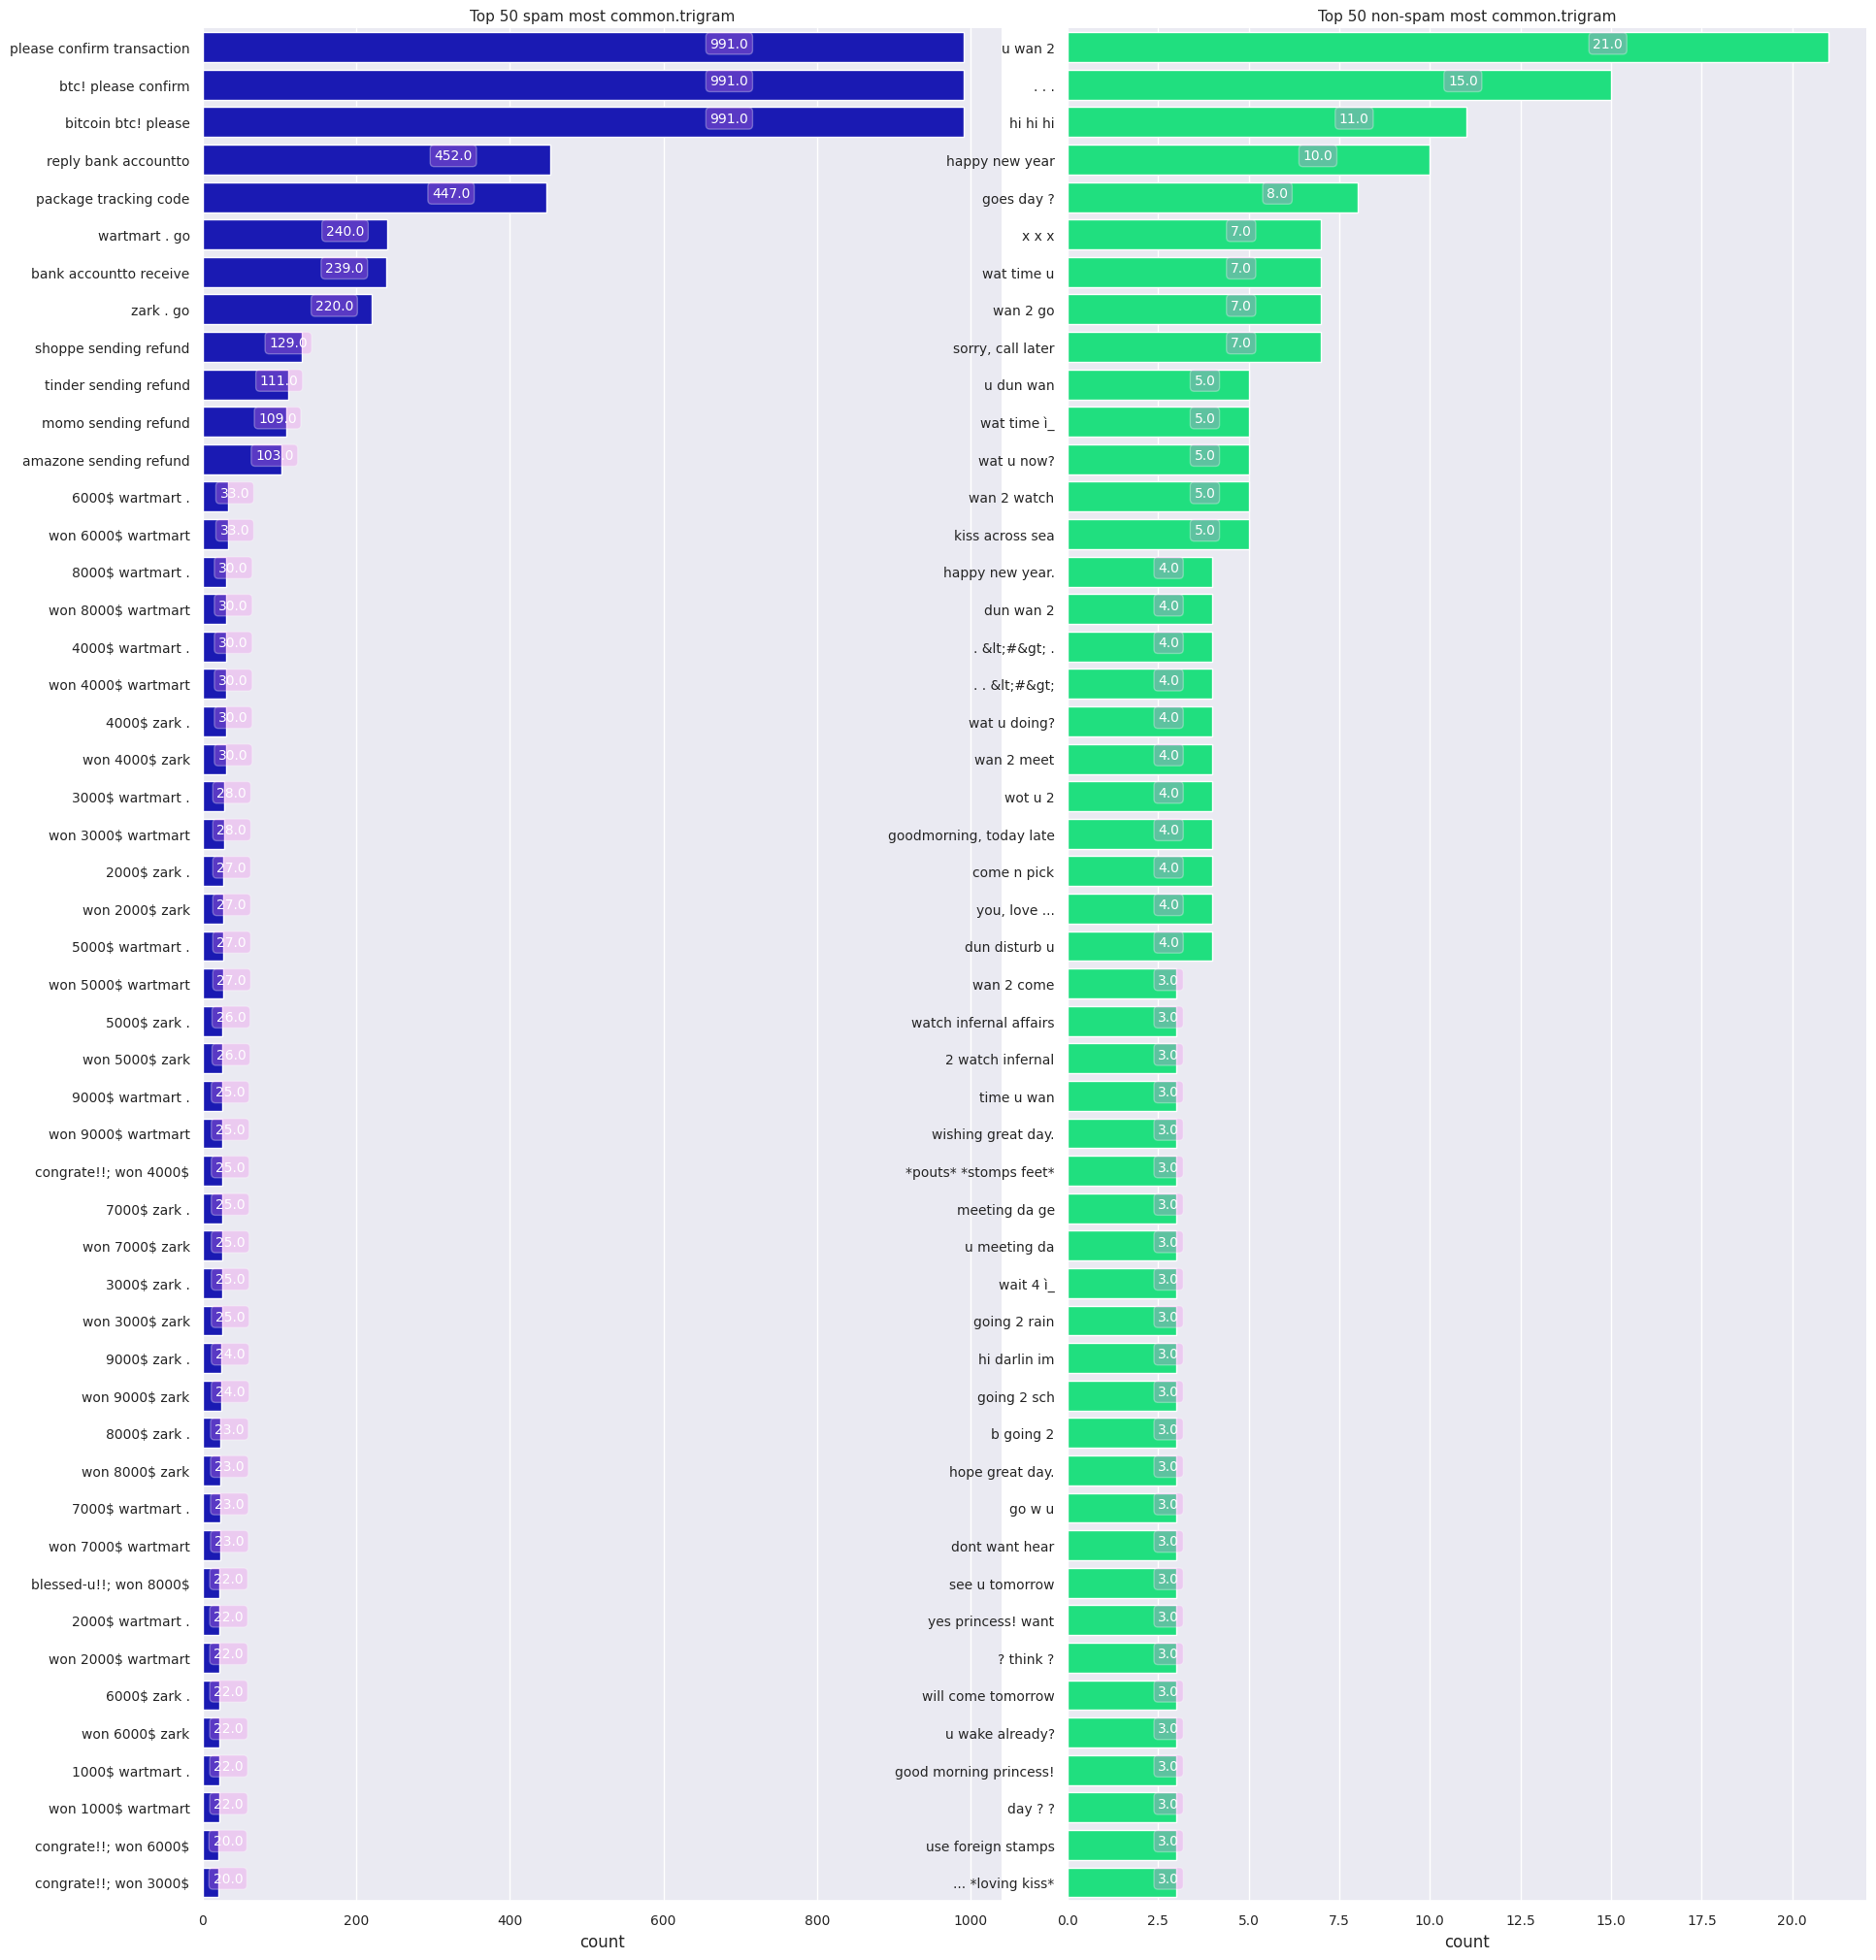

In [17]:
dvnt.N_grams_data_show(spam_df, 'text', 'target', 'spam', 3, 50)

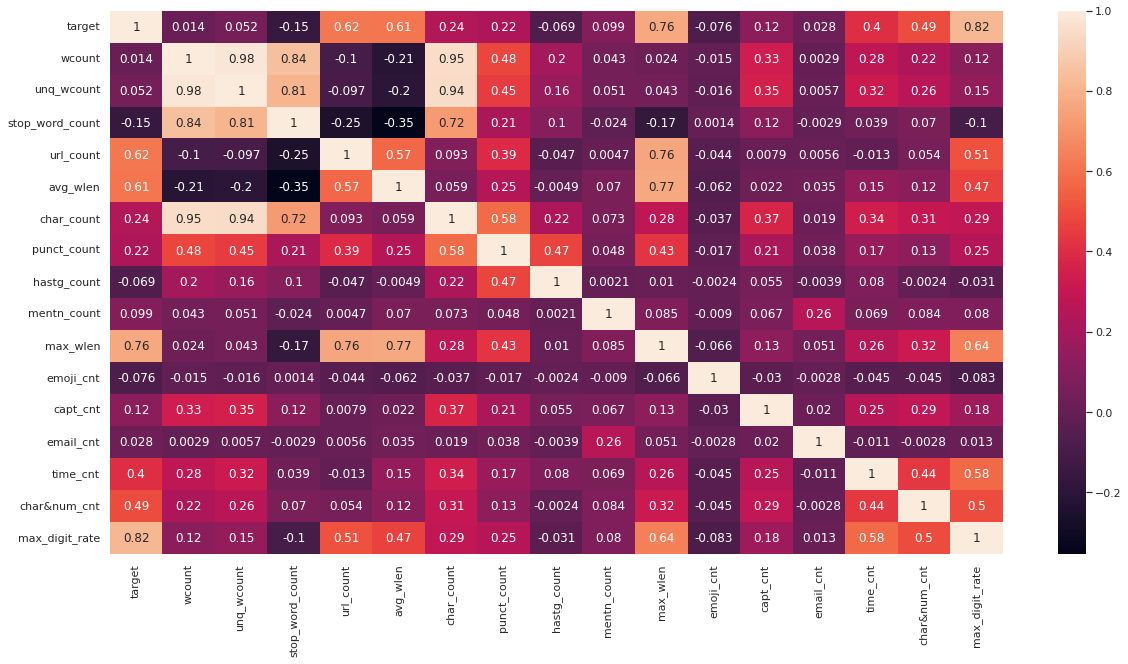

In [18]:
dvnt.advanced_view(encode_data, text_col, clf_col)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%time encode_data = dvnt.view_url_emoij_etc(spam_df, 'text').drop(columns = ['text', 'discription', 'ukn_col', 'key_word'])
encode_data.head()

CPU times: user 13.2 s, sys: 9.06 ms, total: 13.2 s
Wall time: 13.2 s


,target,wcount,unq_wcount,stop_word_count,url_count,avg_wlen,char_count,punct_count,hastg_count,mentn_count,max_wlen,emoji_cnt,capt_cnt,email_cnt,time_cnt,char&num_cnt,max_digit_rate
0,ham,20,20,4,0,4.600000,111,9,0,0,9,0,3,0,0.0,0,0.0
1,ham,6,6,0,0,4.000000,29,6,0,0,6,0,2,0,0.0,0,0.0
2,spam,28,24,5,0,4.571429,155,6,0,0,19,0,10,0,2.0,2,1.0
3,ham,11,10,2,0,3.545455,49,6,0,0,7,0,2,0,0.0,0,0.0
4,ham,13,12,6,0,3.769231,61,2,0,0,6,0,2,0,0.0,0,0.0


Best parameters = {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 200} 
Trained_time = 0.0 minutes, 23.78 seconds 
----------------------------------------------------------------------------------------------------
Split_1. Classification report (on the test-set only).
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98      1506
        spam       0.98      0.97      0.97      1042

    accuracy                           0.98      2548
   macro avg       0.98      0.98      0.98      2548
weighted avg       0.98      0.98      0.98      2548

Split_2. Classification report (on the test-set only).
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98      1505
        spam       0.98      0.97      0.97      1043

    accuracy                           0.98      2548
   macro avg       0.98      0.98      0.98      2548
weighted avg       0.98      0.98      0.98      2548

Split_3. C

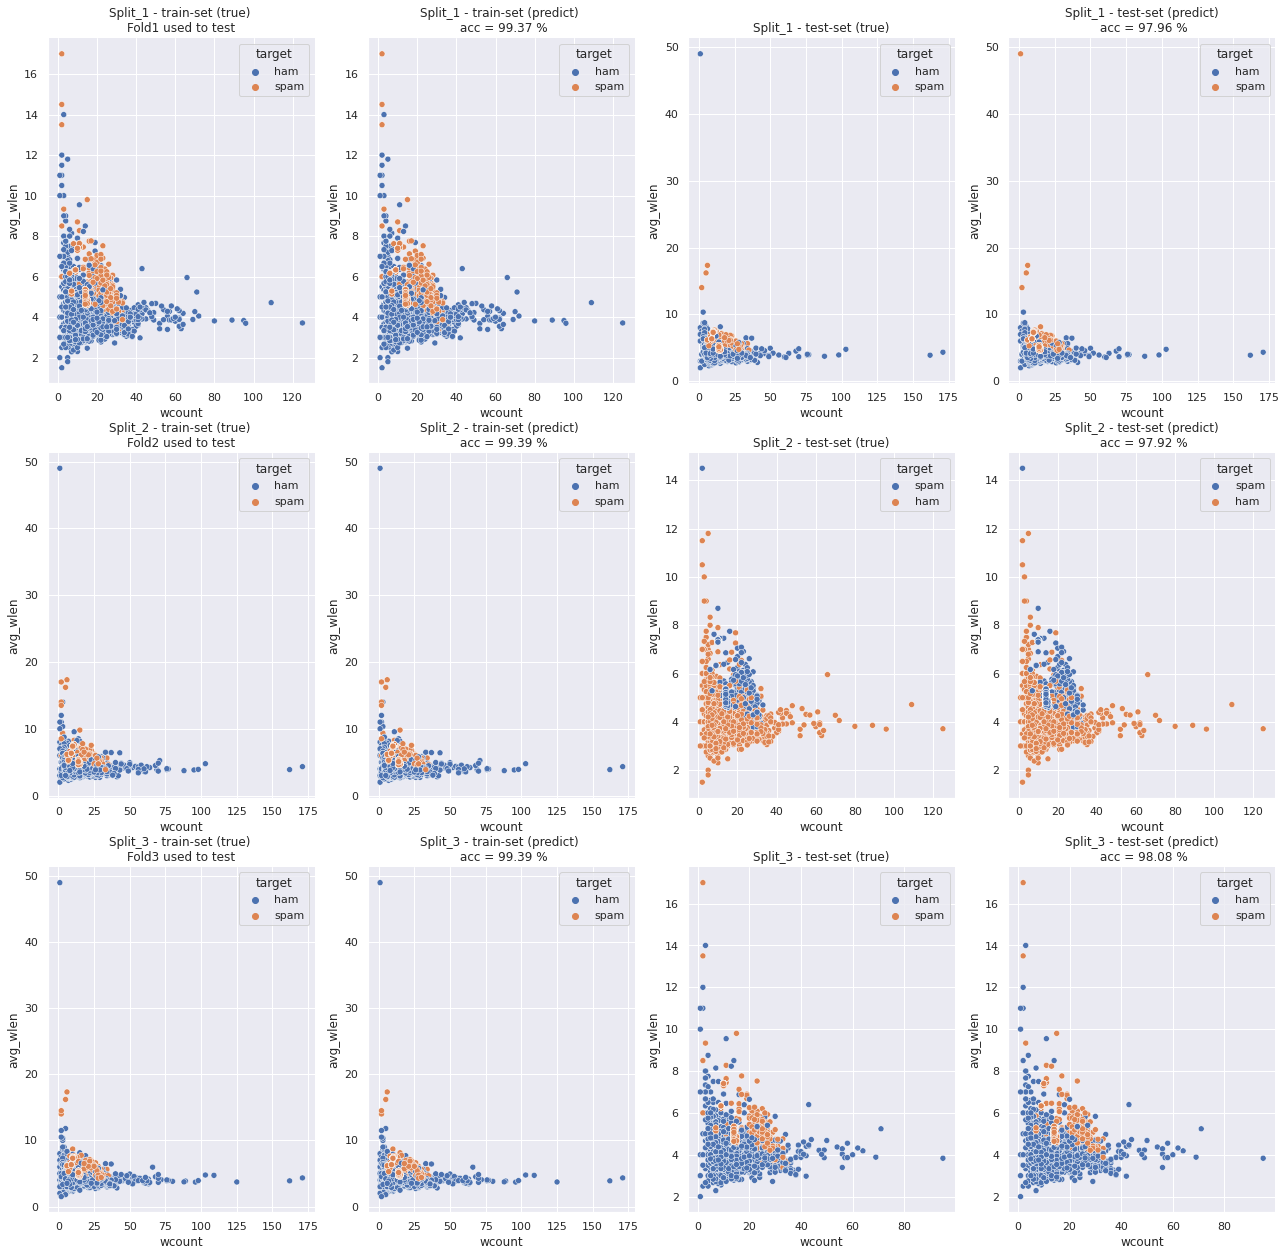

In [20]:
x_name, y_name = 'wcount', 'avg_wlen'
clf = RandomForestClassifier()

grid_params = {'n_estimators': [100, 200, 250],
               'max_depth': [6, 8, 10],
               'min_samples_split': [1, 3]
             }
df1 = dvn_c.k_Fold_Best_params_show_all_(encode_data.fillna(0), 
                                         3, clf, grid_params, 
                                         'target', x_name, y_name, 
                                         show_all = True)

In [21]:
df1

,ROC_AUC,accuracy,f1_score,precison,recall,log_loss(cross-entropy),n_features,best_param
Split_1,0.996665,0.979592,"{'ham': 0.98, 'spam': 0.97}","{'ham': 0.98, 'spam': 0.98}","{'ham': 0.99, 'spam': 0.97}",0.063084,16,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
Split_2,0.997109,0.979199,"{'spam': 0.98, 'ham': 0.97}","{'spam': 0.98, 'ham': 0.98}","{'spam': 0.98, 'ham': 0.97}",0.062832,16,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
Split_3,0.997174,0.980769,"{'ham': 0.98, 'spam': 0.98}","{'ham': 0.98, 'spam': 0.98}","{'ham': 0.99, 'spam': 0.97}",0.057417,16,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
avg_score_k_split,0.996983,0.979853,"{'ham': 0.98, 'spam': 0.9733}","{'ham': 0.98, 'spam': 0.98}","{'ham': 0.98, 'spam': 0.9733}",0.061111,16,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."


### Model 2. Only the Tfidf terms + PCA

In [22]:
spam_df = spam_df.reset_index().rename(columns = {'index': 'id'})
pca_tfidf_data = dvnt.NLP_get_pca_data(spam_df, 'id', 'text', 'target', 100)
pca_tfidf_data.head()

(7644, 100) 0.3445819124225028


,id,target,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,...,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
0,0,ham,0.026452,0.035524,-0.056104,-0.041419,0.099229,-0.040999,0.198129,-0.051204,...,0.005943,-0.070822,0.020734,0.018435,-0.006670,-0.002324,0.005678,-0.018139,-0.067588,0.013680
1,1,ham,0.013130,0.022202,-0.033835,-0.033251,0.121915,-0.087044,0.371408,-0.116661,...,-0.010551,-0.003576,0.007346,0.003146,-0.008240,-0.017116,0.014358,0.011569,0.023796,-0.010019
2,2,spam,0.065618,0.053286,-0.081843,-0.033997,0.036792,0.050965,-0.007843,0.028894,...,0.037783,-0.014109,0.013127,0.073367,-0.068519,-0.039437,-0.051194,0.023378,0.039711,-0.001654
3,3,ham,0.018692,0.031019,-0.046895,-0.043733,0.154605,-0.081312,0.336491,-0.060004,...,-0.029153,0.018738,0.025141,0.028158,-0.008799,-0.071485,0.051025,0.014886,0.002904,-0.064082
4,4,ham,0.053215,0.065936,-0.108397,-0.066494,0.098333,-0.018211,-0.005710,0.005766,...,-0.034846,-0.055580,-0.056859,0.033913,-0.023845,0.019204,0.005196,-0.073848,0.041221,0.031332


Best parameters = {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 250} 
Trained_time = 2.0 minutes, 51.2 seconds 
----------------------------------------------------------------------------------------------------
Split_1. Classification report (on the test-set only).
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97      1506
        spam       1.00      0.91      0.95      1042

    accuracy                           0.96      2548
   macro avg       0.97      0.95      0.96      2548
weighted avg       0.96      0.96      0.96      2548

Split_2. Classification report (on the test-set only).
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97      1505
        spam       1.00      0.91      0.95      1043

    accuracy                           0.96      2548
   macro avg       0.97      0.95      0.96      2548
weighted avg       0.96      0.96      0.96      2548

Split_3. Cl

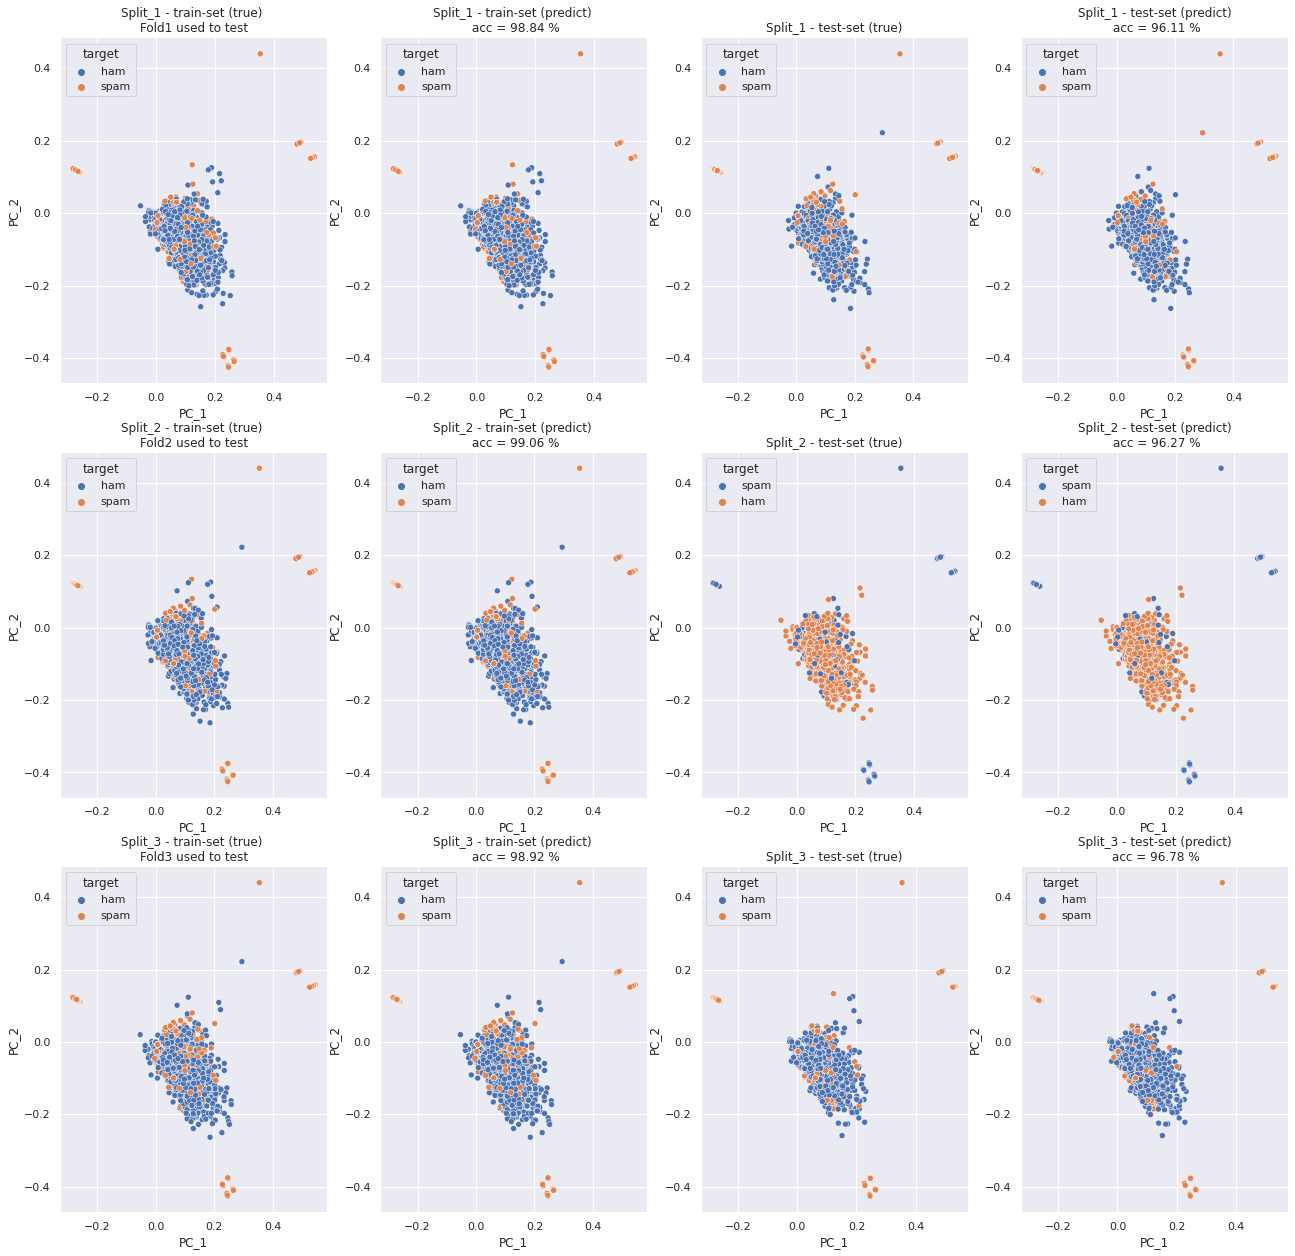

In [23]:
grid_params = {'n_estimators': [100, 200, 250],
               'max_depth': [6, 8, 10],
               'min_samples_split': [1, 3]
             }
df2 = dvn_c.k_Fold_Best_params_show_all_(pca_tfidf_data.fillna(0).drop(columns = 'id'), 
                                         3, clf, grid_params, 
                                         'target', 'PC_1', 'PC_2', 
                                         show_all = True)

In [24]:
df2

,ROC_AUC,accuracy,f1_score,precison,recall,log_loss(cross-entropy),n_features,best_param
Split_1,0.994040,0.961146,"{'ham': 0.97, 'spam': 0.95}","{'ham': 0.94, 'spam': 1.0}","{'ham': 1.0, 'spam': 0.91}",0.119940,100,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
Split_2,0.992755,0.962716,"{'spam': 0.97, 'ham': 0.95}","{'spam': 0.94, 'ham': 1.0}","{'spam': 1.0, 'ham': 0.91}",0.123714,100,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
Split_3,0.992804,0.967818,"{'ham': 0.97, 'spam': 0.96}","{'ham': 0.95, 'spam': 1.0}","{'ham': 1.0, 'spam': 0.92}",0.113861,100,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
avg_score_k_split,0.993200,0.963893,"{'ham': 0.97, 'spam': 0.9533}","{'ham': 0.9433, 'spam': 1.0}","{'ham': 0.97, 'spam': 0.9533}",0.119172,100,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."


- In model 1, we need only 16 features to get 98% accuracy while we used 100 features in model2 but can not exceed 97% accuracy

### Comibe both of them

In [25]:
spam_df = spam_df.reset_index().rename(columns = {'index': 'id'})
pca_tfidf_data = dvnt.NLP_get_pca_data(spam_df, 'id', 'text', 'target', 100)
full_df = pd.concat([encode_data, pca_tfidf_data.drop(columns = ['id', 'target'])], axis = 1)
full_df.head()

(7644, 100) 0.3443589720973118


,target,wcount,unq_wcount,stop_word_count,url_count,avg_wlen,char_count,punct_count,hastg_count,mentn_count,...,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
0,ham,20,20,4,0,4.600000,111,9,0,0,...,0.003864,0.016342,0.021835,-0.034960,-0.051286,0.079166,-0.001958,0.002193,0.050059,0.024570
1,ham,6,6,0,0,4.000000,29,6,0,0,...,-0.015298,-0.016169,0.002308,-0.023540,0.041328,0.000250,0.009039,0.014177,-0.006831,0.025654
2,spam,28,24,5,0,4.571429,155,6,0,0,...,-0.036289,-0.036467,-0.009824,-0.036576,-0.024938,0.035218,-0.042002,-0.096299,0.045825,-0.011877
3,ham,11,10,2,0,3.545455,49,6,0,0,...,-0.056440,-0.021300,-0.004312,0.023324,0.019715,0.026677,0.021248,0.094855,0.096017,-0.008007
4,ham,13,12,6,0,3.769231,61,2,0,0,...,-0.041429,-0.044529,0.015656,0.032921,-0.080885,-0.019557,0.014718,0.040821,0.093147,-0.072693


Best parameters = {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 250} 
Trained_time = 1.0 minutes, 56.7 seconds 
----------------------------------------------------------------------------------------------------
Split_1. Classification report (on the test-set only).
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1506
        spam       0.99      0.97      0.98      1042

    accuracy                           0.98      2548
   macro avg       0.98      0.98      0.98      2548
weighted avg       0.98      0.98      0.98      2548

Split_2. Classification report (on the test-set only).
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1505
        spam       0.99      0.96      0.98      1043

    accuracy                           0.98      2548
   macro avg       0.98      0.98      0.98      2548
weighted avg       0.98      0.98      0.98      2548

Split_3. Cl

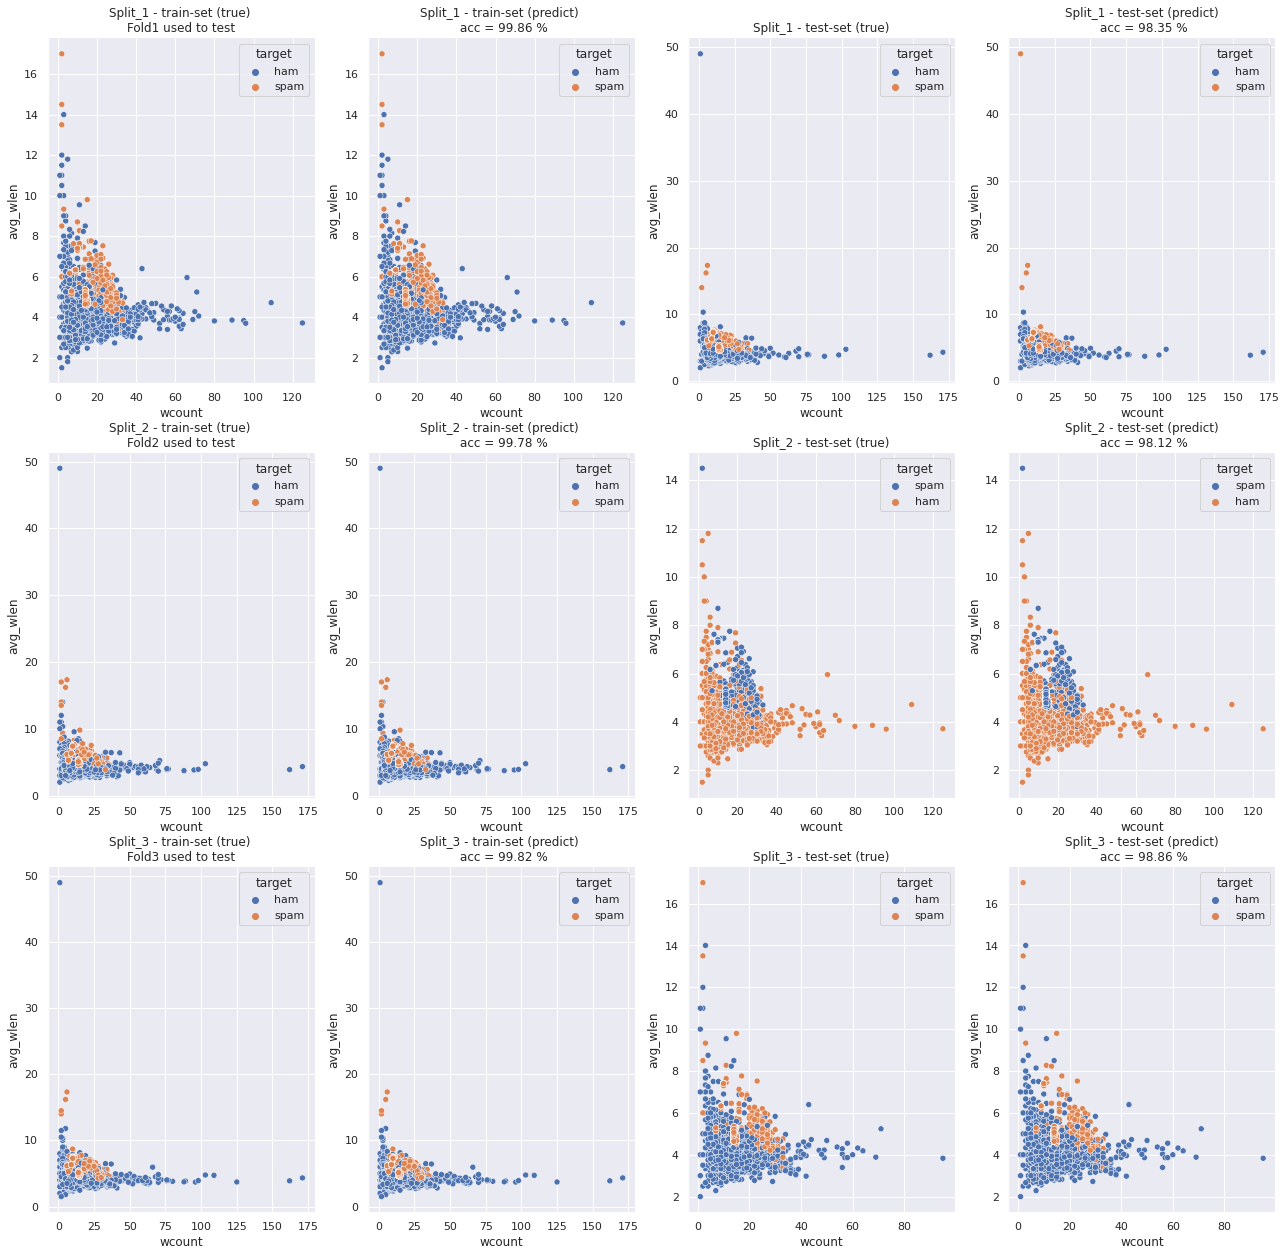

In [27]:
df3 = dvn_c.k_Fold_Best_params_show_all_(full_df.fillna(0), 
                                         3, clf, grid_params, 
                                         'target', 'wcount', 'avg_wlen', 
                                         show_all = True)

In [28]:
df3

,ROC_AUC,accuracy,f1_score,precison,recall,log_loss(cross-entropy),n_features,best_param
Split_1,0.997579,0.983516,"{'ham': 0.99, 'spam': 0.98}","{'ham': 0.98, 'spam': 0.99}","{'ham': 0.99, 'spam': 0.97}",0.066963,116,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
Split_2,0.998298,0.981162,"{'spam': 0.98, 'ham': 0.98}","{'spam': 0.97, 'ham': 0.99}","{'spam': 1.0, 'ham': 0.96}",0.067628,116,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
Split_3,0.998082,0.988619,"{'ham': 0.99, 'spam': 0.99}","{'ham': 0.98, 'spam': 1.0}","{'ham': 1.0, 'spam': 0.98}",0.061703,116,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
avg_score_k_split,0.997986,0.984432,"{'ham': 0.9867, 'spam': 0.9833}","{'ham': 0.9767, 'spam': 0.9933}","{'ham': 0.9867, 'spam': 0.9833}",0.065431,116,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."


### Summary

In [29]:
result = pd.concat([
                   df1.loc['avg_score_k_split'].rename("Spam_characteristic"),
                   df2.loc['avg_score_k_split'].rename("PCA_the_Tfidf"),
                   df3.loc['avg_score_k_split'].rename("Combine_both_above")
                  ], 
                    axis = 1
                ).T.sort_values(by = 'ROC_AUC', ascending = False)
result

,ROC_AUC,accuracy,f1_score,precison,recall,log_loss(cross-entropy),n_features,best_param
Combine_both_above,0.997986,0.984432,"{'ham': 0.9867, 'spam': 0.9833}","{'ham': 0.9767, 'spam': 0.9933}","{'ham': 0.9867, 'spam': 0.9833}",0.065431,116,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
Spam_characteristic,0.996983,0.979853,"{'ham': 0.98, 'spam': 0.9733}","{'ham': 0.98, 'spam': 0.98}","{'ham': 0.98, 'spam': 0.9733}",0.061111,16,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."
PCA_the_Tfidf,0.9932,0.963893,"{'ham': 0.97, 'spam': 0.9533}","{'ham': 0.9433, 'spam': 1.0}","{'ham': 0.97, 'spam': 0.9533}",0.119172,100,"{'max_depth': 10, 'min_samples_split': 3, 'n_e..."


#### Comments
- Another approach is using Word-Embedding, which be discussed in [NLP_Embeddding](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/US-Embassy_DS-course/Class%203/NLP_Embedding.ipynb)
- Noting that in spam-detection, the accuracy will be improved the best in case that we found the most features which made the message become spam